# Clustering of Travel Reviews


## Introduction / Overview
The dataset we will be working with in this task has no targets given. So we will investigate what the ideal number of clusters is for the dataset, the natural clusters.

We will also attempt finding which algorithm is the best at finding the natural clusters. The comparisons will be done with two different algorithms. The elbow method and the silhouette method.


## The dataset

- #### What is the purpose of this dataset?
The purpose of this dataset is to analyze traveler ratings from East Asian destinations across ten categories, using reviews collected from TripAdvisor. Each traveler rating is mapped from a continuous value between 0 and 4. Where 0 is the worst and 4 is the best. The average of the ratings is used against each category, per user.

- #### What are the features? 

The features represent data that capture the average user feedback across ten different categories: art galleries, dance clubs, juice bars, restaurants, museums, resorts, parks/picnic spots, beaches, theaters, and religious institutions. These feedback scores provide insights into user preferences across these different categories.

- #### What are the targets? 

This dataset does not contain a target. So we will explore, and look to identify some patterns and try to understand the relationships between them.


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

In [25]:
coloumn_names = ['User ID',
               'Art galleries',
               'Dance clubs',
               'Juice bars',
               'Restaurants',
               'Museums',
               'Resorts',
               'Parks/Picnic',
               'Beaches',
               'Theater',
               'Religious institutions '
               ]

In [26]:
trip_advisor_review_csv = pd.read_csv('tripadvisor_review.csv',sep=',')
dataset = trip_advisor_review_csv
dataset.columns = coloumn_names
dataset = trip_advisor_review_csv.drop('User ID', axis=1)
dataset.head()

,Art galleries,Dance clubs,Juice bars,Restaurants,Museums,Resorts,Parks/Picnic,Beaches,Theater,Religious institutions
0,0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1,1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
2,1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
3,0.45,1.8,0.29,0.57,0.46,1.52,3.18,2.96,1.57,2.86
4,0.51,1.2,1.18,0.57,1.54,2.02,3.18,2.78,1.18,2.54


## Correlation matrix

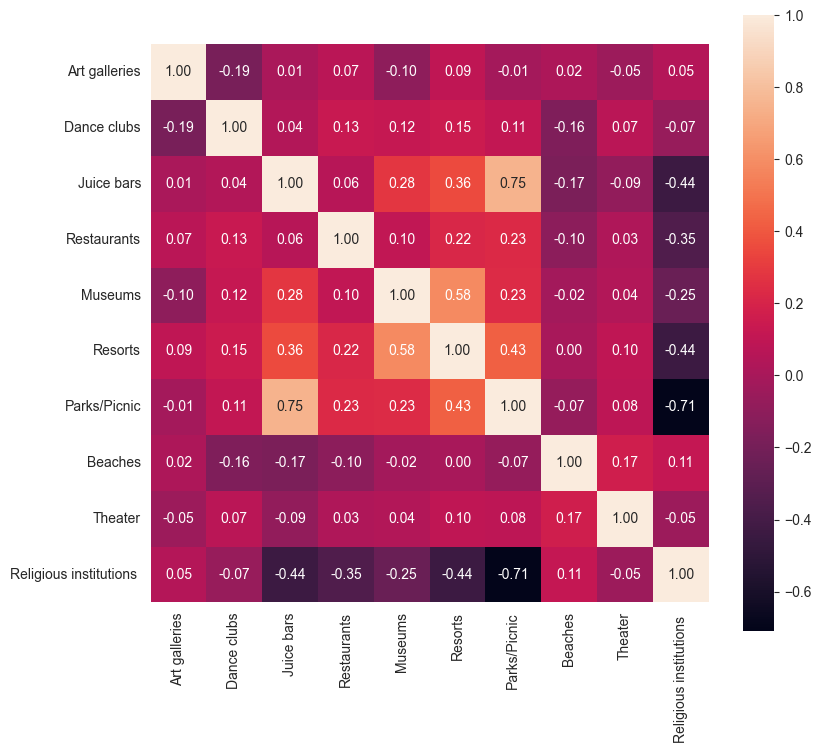

In [27]:
corrmat = dataset.corr()
fig, ax = plt.subplots(figsize=(9,8))
sb.heatmap(corrmat,ax=ax, square=True,annot=True, fmt='.2f');

## Interpreting the Correlation matrix
A few correlations stand out here.

- Park/Picnic and Juice bars

- Resorts and Juice bars

- Resorts and museums


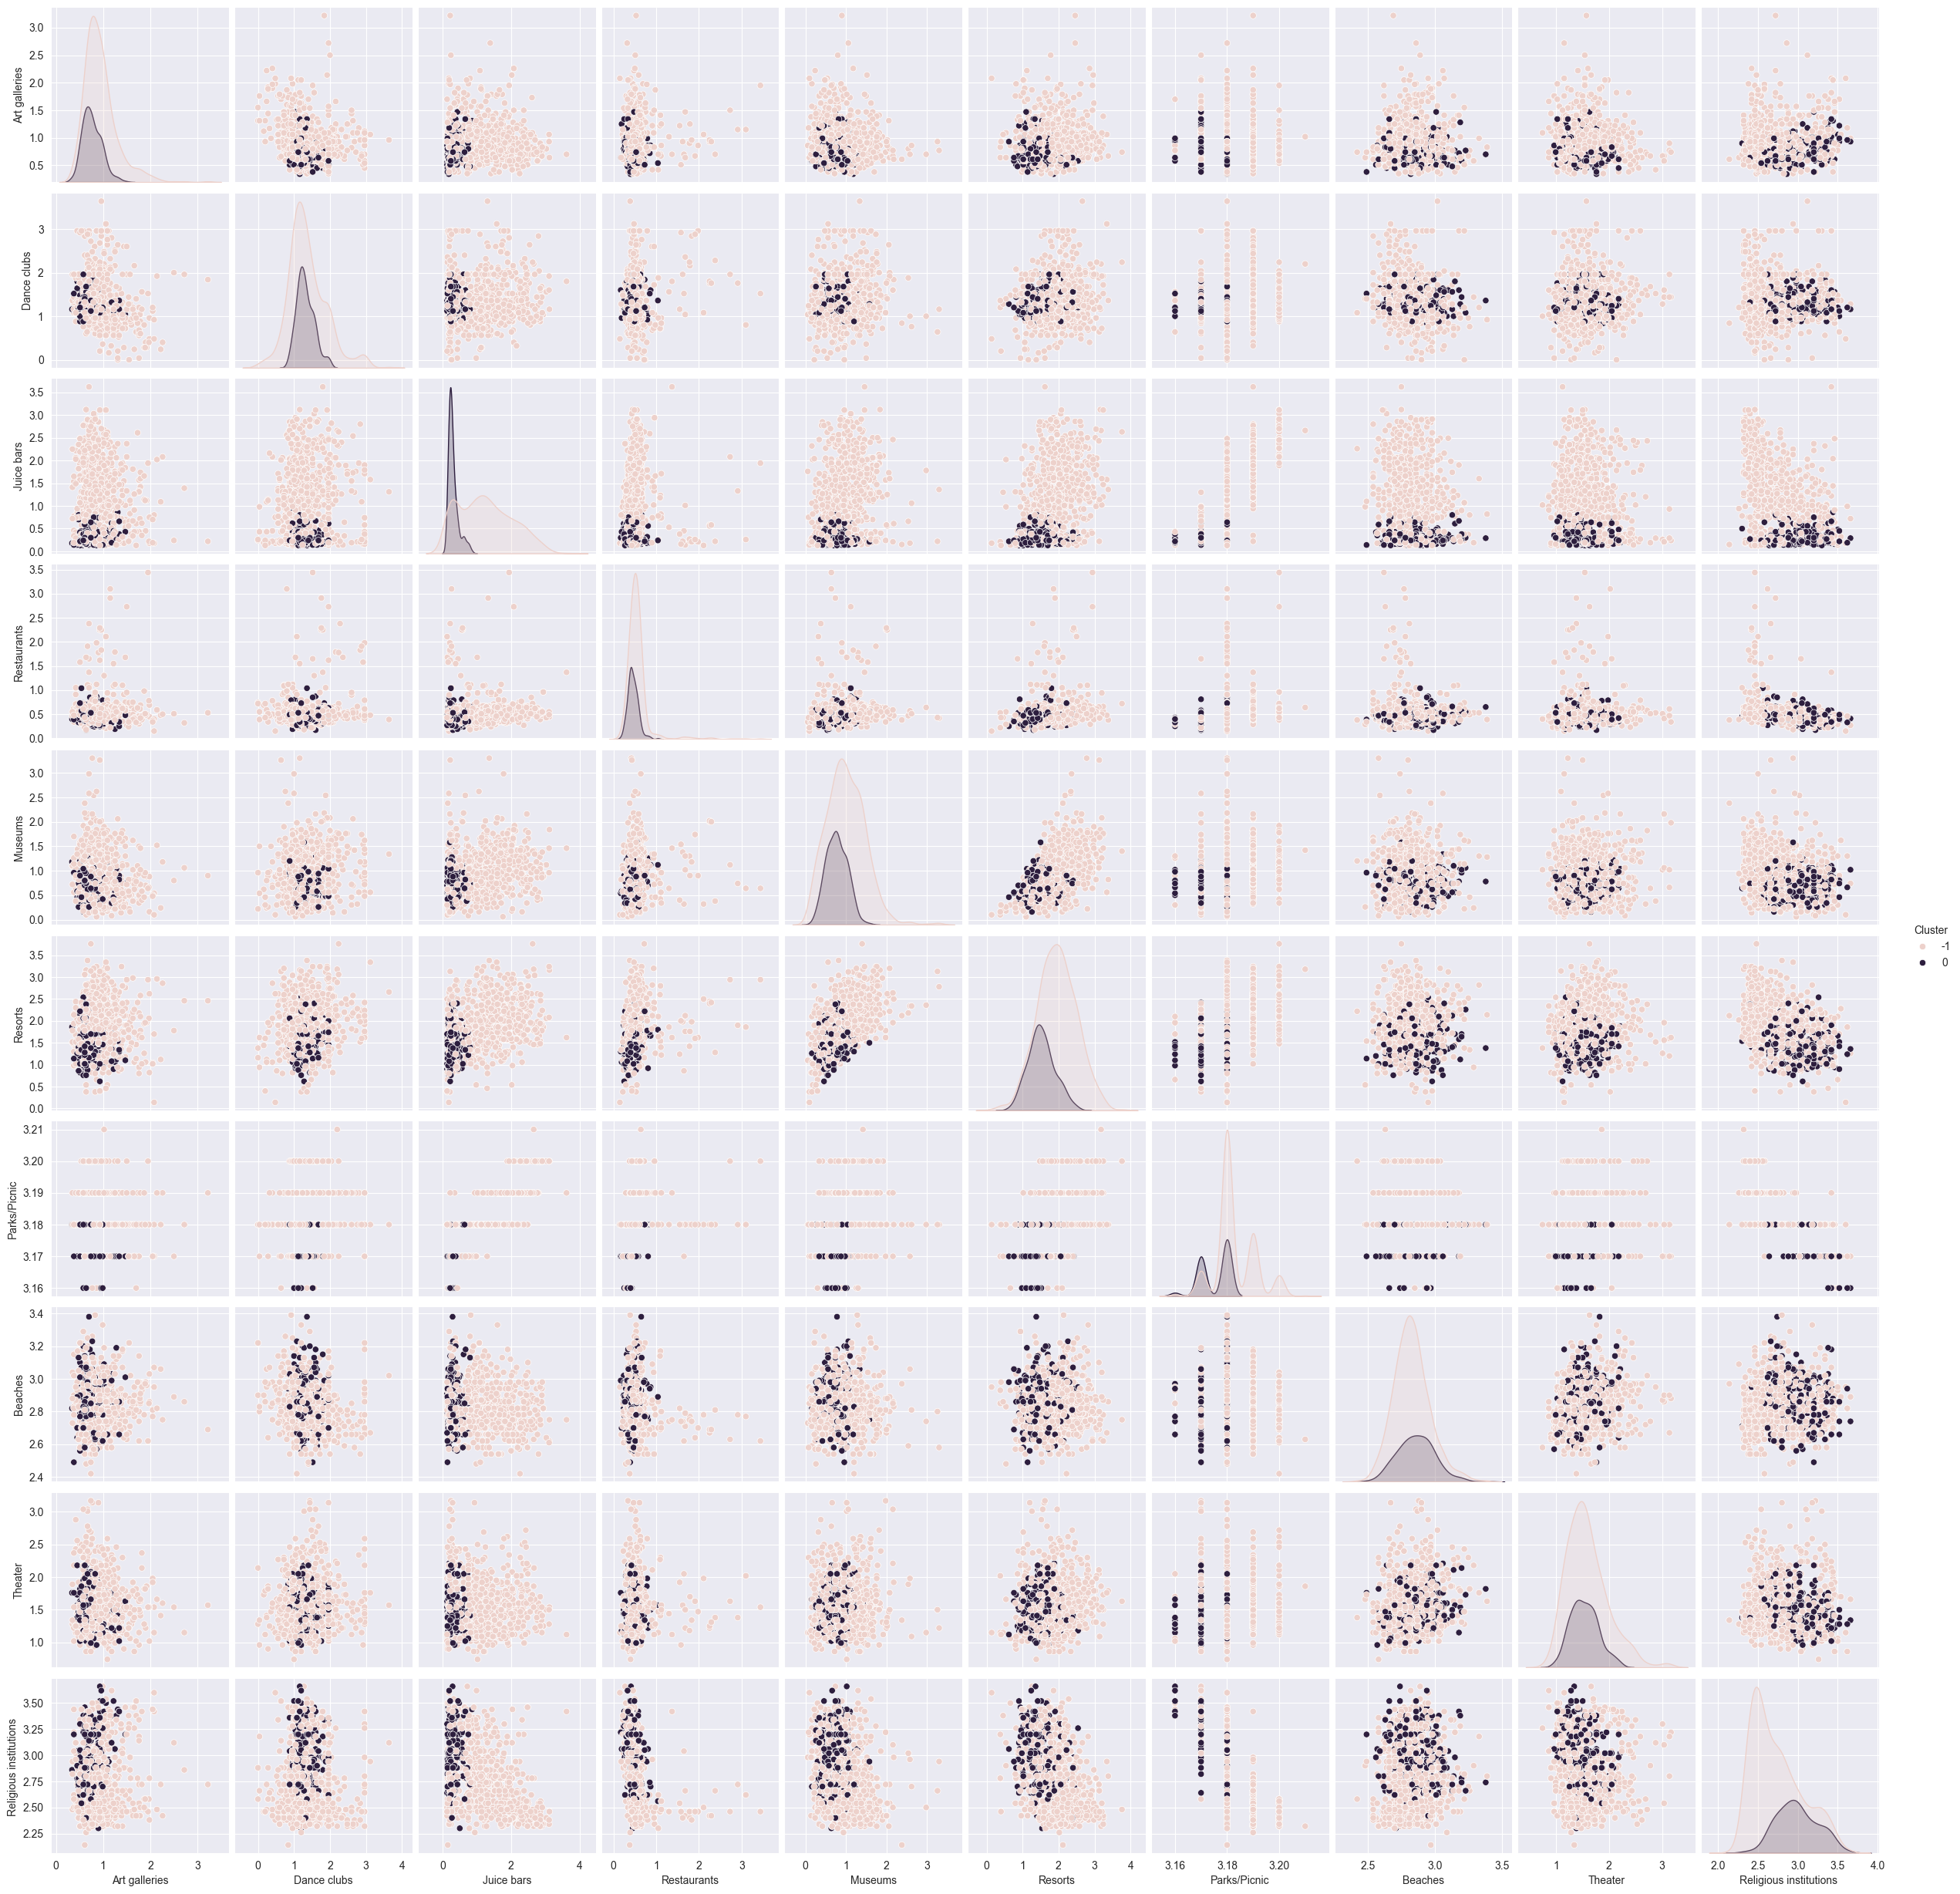

In [64]:

sb.pairplot(dataset, hue='Cluster')
plt.show()

## Boxplot

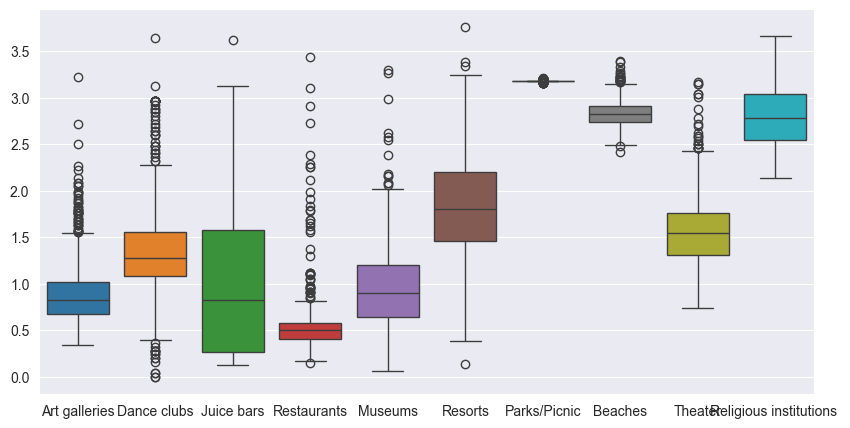

In [28]:
plt.figure(figsize=(10, 5))
fig = sb.boxplot(data=dataset)

## Histogram

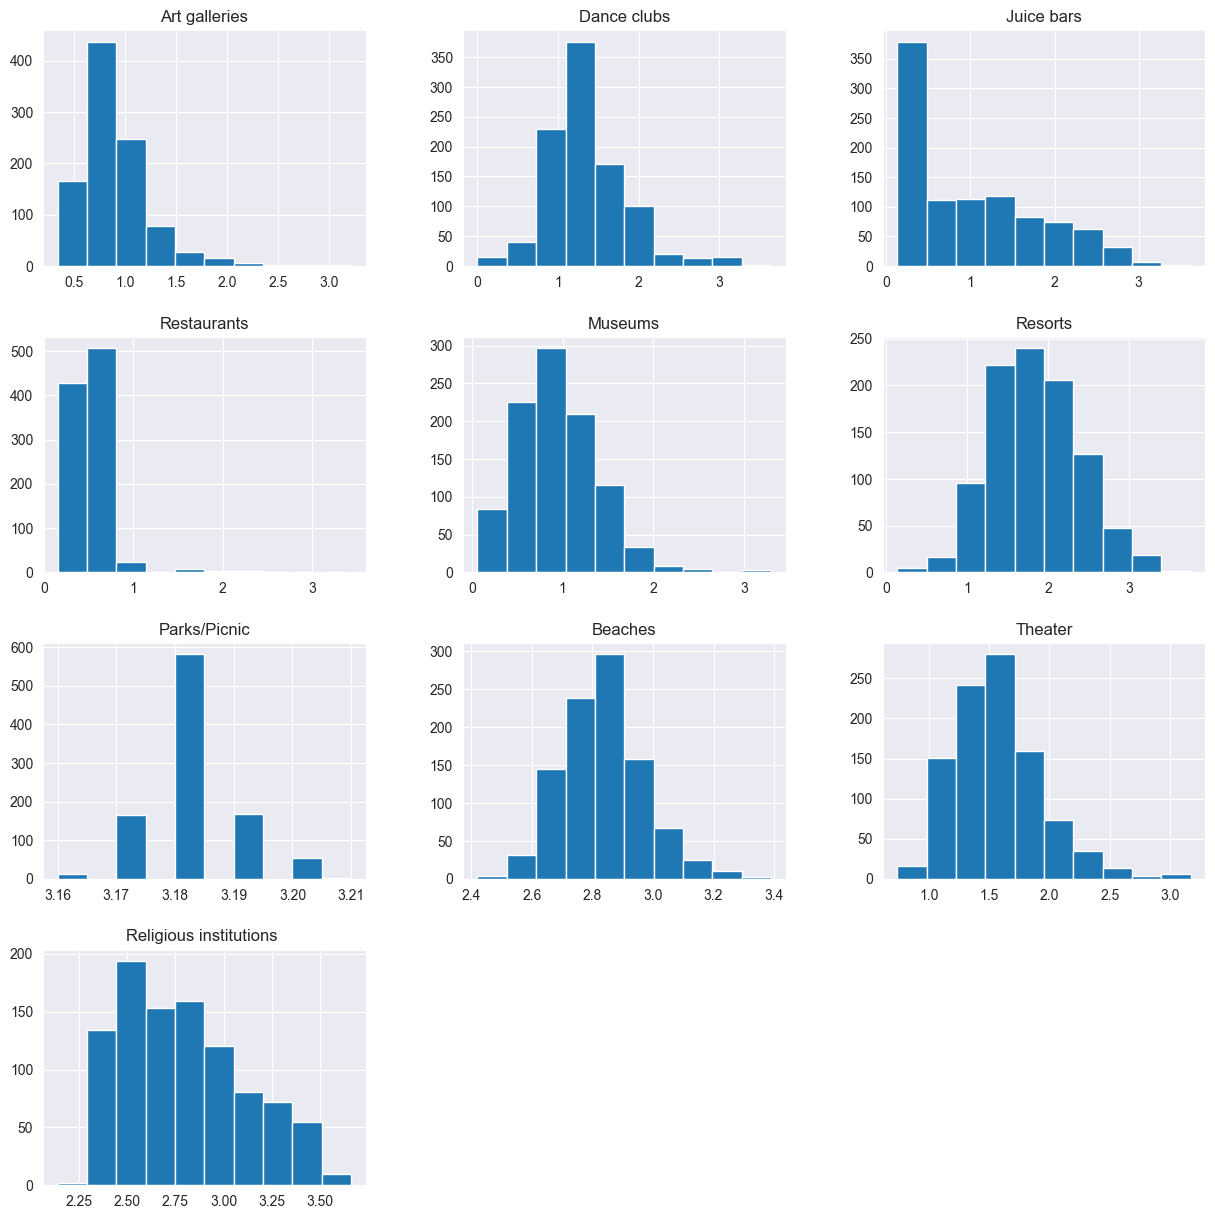

In [29]:
dataset.hist(figsize=(15,15));

## Explore the dataset using distribution and correlation analysis

After the studying the histograms from our dataset, a few observations was made.
- Most of the categories have the shape of normal distribution, we can observe that by seeing kind of a curve that peaks in the middle. However, some are not centered.
- Category 3 and 4 are features I interpret as skewed, meaning that there is an uneven distribution, which will make our model uneven if we dont process it.


## Normalizing dataset
Here we will use a min max scaler to normalize our dataset. This might help with our skewed features *FOR K-MEANS*.

In [30]:
dataset_normalized = pd.DataFrame(MinMaxScaler().fit_transform(dataset))


## What did this do?

Now the dataset has its x axis only between 0 and 1 which kind of compresses the previous value which was 0 to 4.

## Did it change much?

Besides the x axis being compressed, we can see that the histograms are almost identical to as before.

## Using PCA

We will use Principal Component Analysis to compress and reduce our variables to less components.

## Finding the amount of PCA components to compress to


In [31]:
pca = PCA().fit(dataset)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.90) + 1  # Finding number of components that explain 90% variance
print(f"number of components that explain 90% variance: {n_components}")

number of components that explain 90% variance: 6


In [32]:
pca = PCA().fit(dataset_normalized)
explained_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(explained_variance >= 0.90) + 1  # Finding number of components that explain 90% variance
print(f"number of components that explain 90% variance: {n_components}")

number of components that explain 90% variance: 7


## What does this tell us?
With 90% explained variance, we retain 90% of the dataset's variation even though it’s compressed. This helps preserve the important patterns and information while reducing the dataset's dimensionality.

For the dataset this tells us that we need 6 components, if we were to use PCA on that dataset.

For the normalized dataset this tells us we need 7 components, if we were to use PCA on the normalized dataset.

If we were to try having a lower explained variance, for example 80%, we might get better results. However, by doing this, we make the problem easier, which can lead to a misrepresentation. 

In [33]:
pca_dataset = PCA(6).fit(dataset)
pca_dataset_reduced = pd.DataFrame(pca_dataset.transform(dataset))
pca_dataset_reduced.shape

(980, 6)

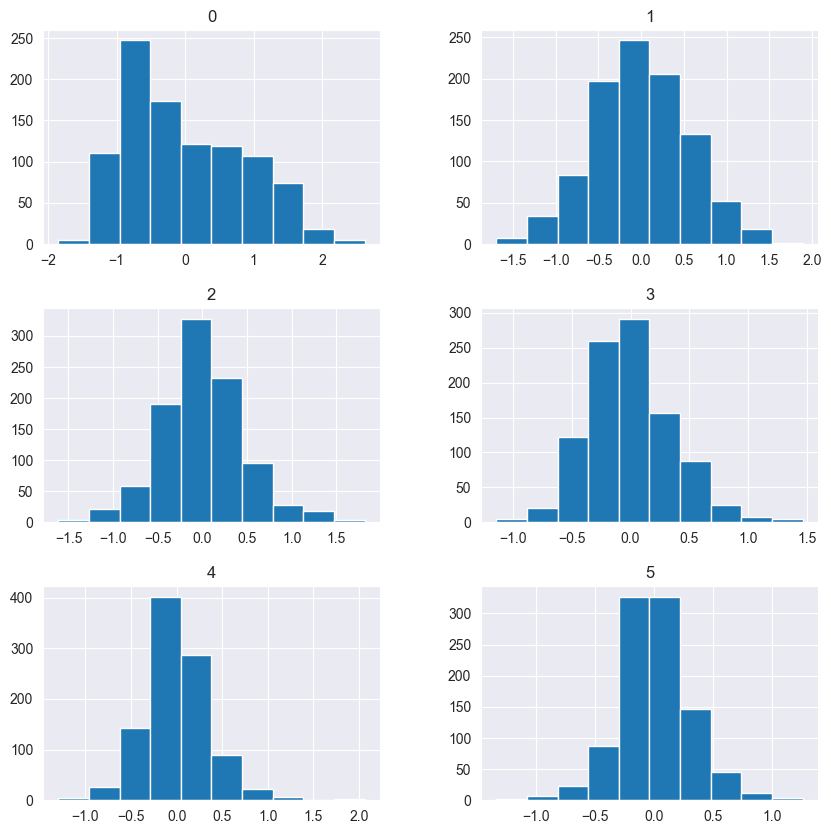

In [34]:
pca_dataset_reduced.hist(figsize=(10,10));

## PCA using the normalized dataset

In [35]:
pca_normalized = PCA(7).fit(dataset_normalized)
pca_normalized_reduced = pd.DataFrame(pca_normalized.transform(dataset_normalized))
pca_normalized_reduced.shape

(980, 7)

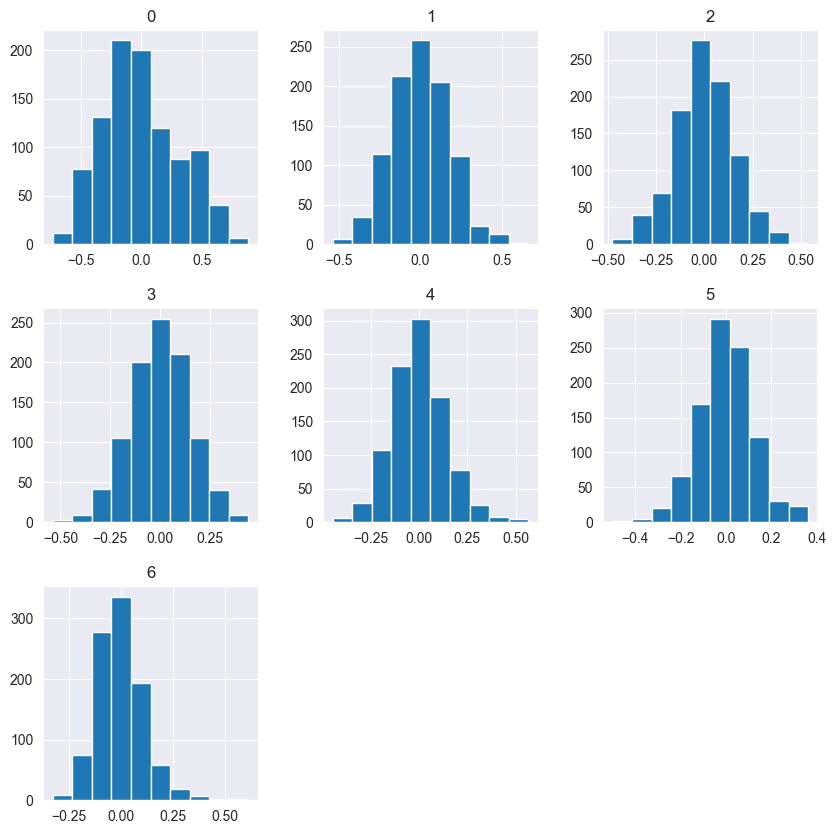

In [36]:
pca_normalized_reduced.hist(figsize=(10,10));

## PCA normalized histograms observation

We see now that all of the features are now having a convenient normal distribution.

## Trying boxplot with our PCA datasets

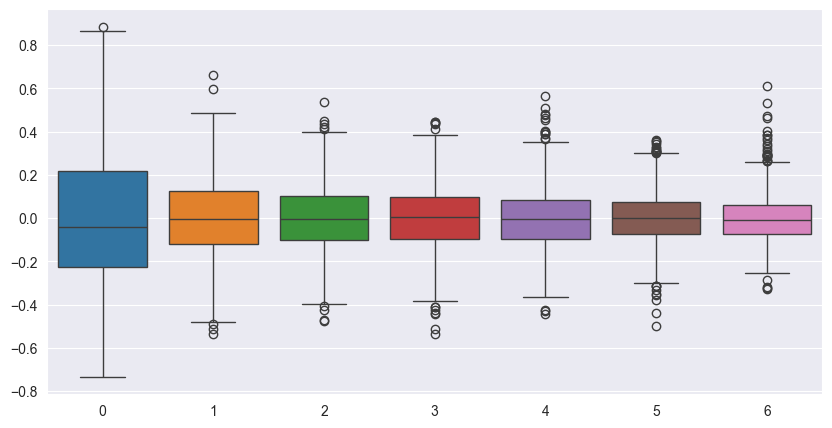

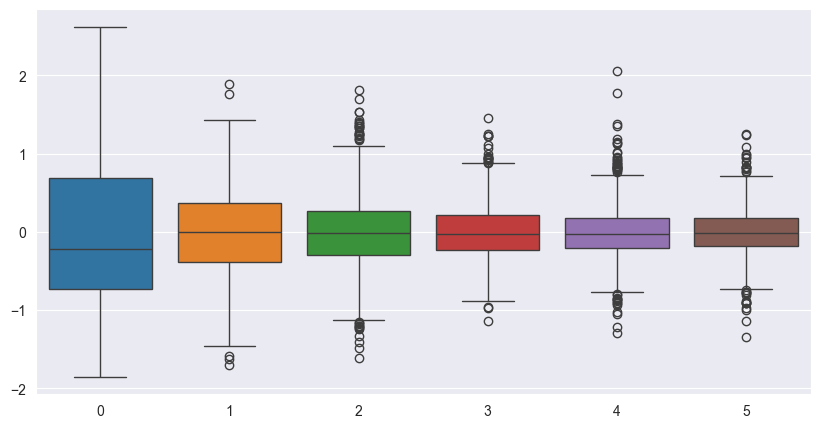

In [37]:
plt.figure(figsize=(10, 5))
fig = sb.boxplot(pca_normalized_reduced)

plt.figure(figsize=(10, 5))
fig2 = sb.boxplot(pca_dataset_reduced)

## The results of the new boxplot

We can see a clear improvement from our first boxplot, now there is a clear correleation between them. 
However, I also have a slight impression that the PCA made them so they are too reduced. 

## Using elbow method to find the optimal amount of clusters

The reason for choosing this method, is because it helps us determine the optimal number of clusters by plotting the variance against the number of clusters. So in essence we are trying to find a balance where adding more clusters will give us less improvements. The optimal number of clusters will capture the structure of the data without overfitting.

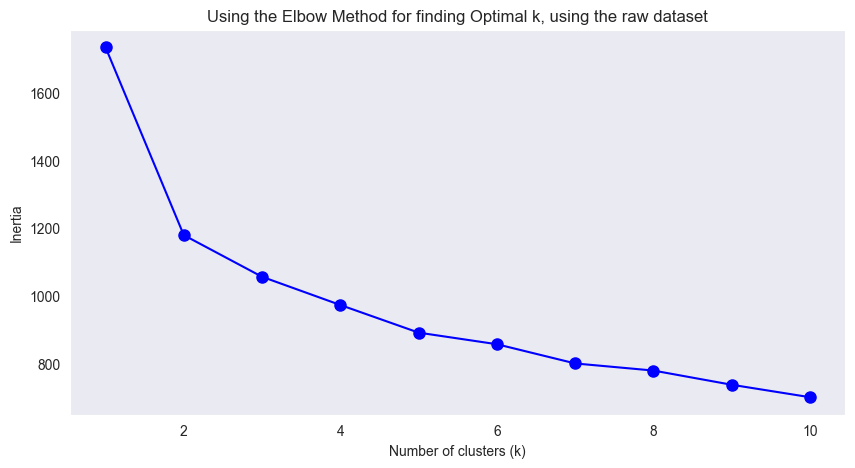

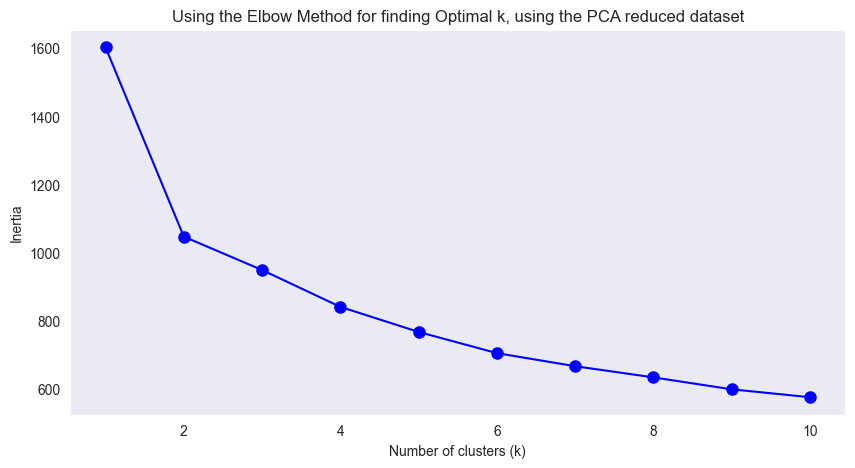

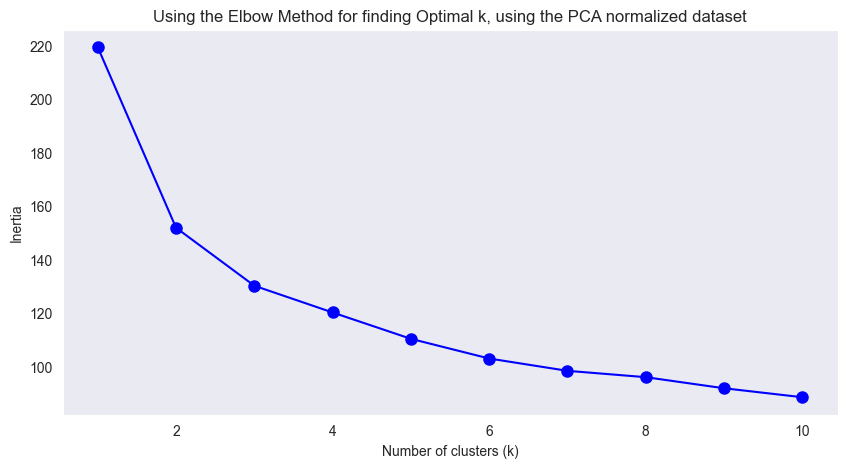

In [38]:
def plot_inertia(k_range, inertia, title):
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, inertia, 'bo-', markersize=8)
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title(title)
    plt.grid()
    plt.show()

# List of datasets and corresponding titles
datasets = [
    (dataset, 'Using the Elbow Method for finding Optimal k, using the raw dataset'),
    (pca_dataset_reduced, 'Using the Elbow Method for finding Optimal k, using the PCA reduced dataset'),
    (pca_normalized_reduced, 'Using the Elbow Method for finding Optimal k, using the PCA normalized dataset')
]

k_range = range(1, 11)

for data, title in datasets:
    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    plot_inertia(k_range, inertia, title)


## Observing the drop in the graph using the elbow method, and deciding the the k

We can observe that the inertia of the k slows down significantly after hitting 2 cluster.There’s no clear elbow, but a noticeable bend occurs around k=3. and the curve starts flattening around k=3 to k5. So I will try both k=3 and k=4 and compare the results between the two.


## Using silhouete method to find the amount of clusters


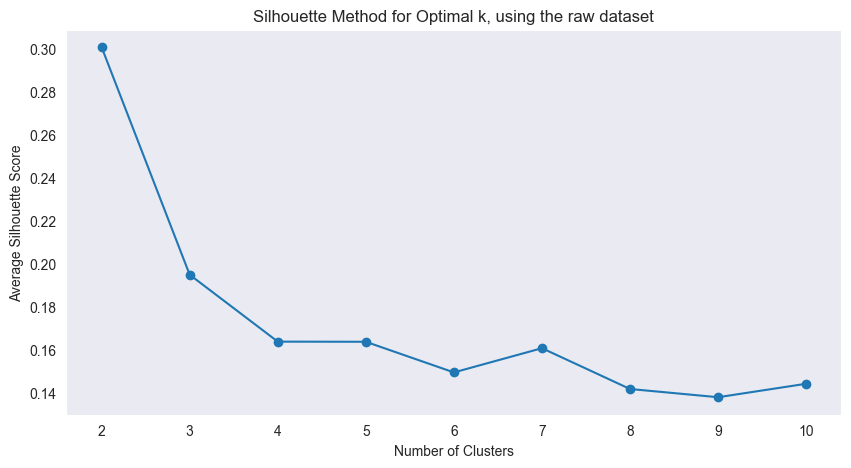

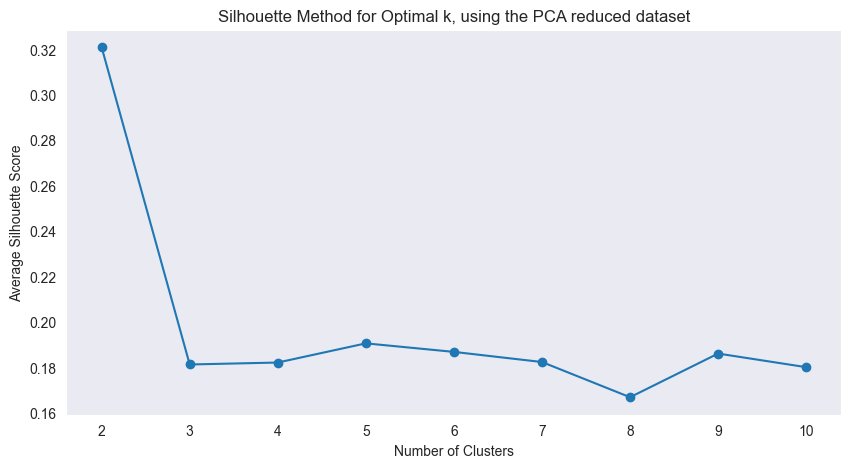

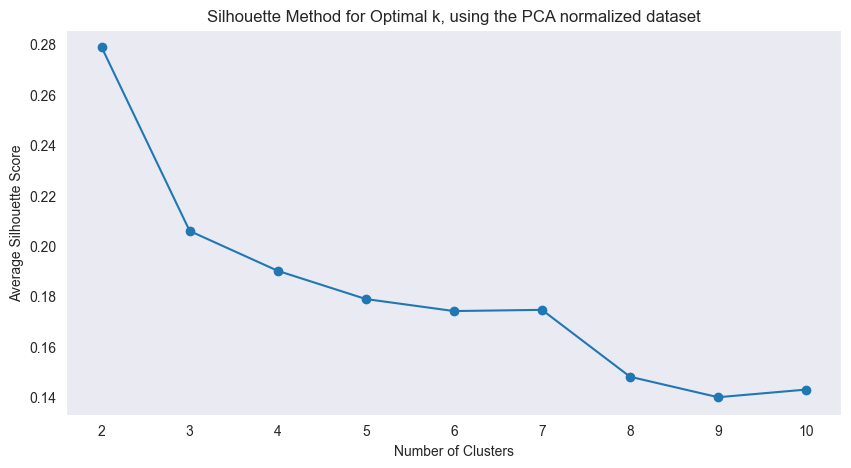

In [39]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def plot_silhouette_scores(range_n_clusters, silhouette_avg, title):
    plt.figure(figsize=(10, 5))
    plt.plot(range_n_clusters, silhouette_avg, marker='o')
    plt.title(title)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Average Silhouette Score')
    plt.xticks(range_n_clusters)
    plt.grid()
    plt.show()

datasets = [
    (dataset, 'Silhouette Method for Optimal k, using the raw dataset'),
    (pca_dataset_reduced, 'Silhouette Method for Optimal k, using the PCA reduced dataset'),
    (pca_normalized_reduced, 'Silhouette Method for Optimal k, using the PCA normalized dataset')
]

range_n_clusters = range(2, 11)

for data, title in datasets:
    silhouette_avg = []
    for k in range_n_clusters:
        clusterer = KMeans(n_clusters=k, random_state=42)
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg.append(silhouette_score(data, cluster_labels))
    
    plot_silhouette_scores(range_n_clusters, silhouette_avg, title)


Interpreting the silhouette method a place with k=3 or k=4

# Creating our cluster algorithms

## Creating our KMeans cluster

In [40]:
datasets = [
    (dataset, "dataset", 3),
    (dataset_normalized, "dataset_normalized", 3),
    (pca_dataset_reduced, "pca_dataset_reduced", 3),
    (pca_normalized_reduced, "pca_normalized_reduced", 3),
    (dataset, "dataset", 4),
    (dataset_normalized, "dataset_normalized", 4),
    (pca_dataset_reduced, "pca_dataset_reduced", 4),
    (pca_normalized_reduced, "pca_normalized_reduced", 4),
]

for data, data_name, n_clusters in datasets:
    print(f"Model with {n_clusters} clusters on {data_name}:")
    
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_model.fit(data)
    
    silhouette = silhouette_score(data, kmeans_model.labels_)
    davies_bouldin = davies_bouldin_score(data, kmeans_model.labels_)
    
    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Score: {davies_bouldin}\n")


Model with 3 clusters on dataset:
Silhouette Score: 0.1951223938451225
Davies-Bouldin Score: 1.8181466695307649

Model with 3 clusters on dataset_normalized:
Silhouette Score: 0.19049716495174232
Davies-Bouldin Score: 1.7758370611604988

Model with 3 clusters on pca_dataset_reduced:
Silhouette Score: 0.18127248370219373
Davies-Bouldin Score: 1.8044287789818616

Model with 3 clusters on pca_normalized_reduced:
Silhouette Score: 0.20589127072168928
Davies-Bouldin Score: 1.6850620550826825

Model with 4 clusters on dataset:
Silhouette Score: 0.16401823215666964
Davies-Bouldin Score: 1.728451579641661

Model with 4 clusters on dataset_normalized:
Silhouette Score: 0.1727977932255177
Davies-Bouldin Score: 1.7728662308013592

Model with 4 clusters on pca_dataset_reduced:
Silhouette Score: 0.18213360435909146
Davies-Bouldin Score: 1.6015963117140262

Model with 4 clusters on pca_normalized_reduced:
Silhouette Score: 0.19007601184066888
Davies-Bouldin Score: 1.6659738776955515



## Tuning hyperparameters

In [41]:
datasets = [
    (dataset, "dataset", 3),
    (dataset_normalized, "dataset_normalized", 3),
    (pca_dataset_reduced, "pca_dataset_reduced", 3),
    (pca_normalized_reduced, "pca_normalized_reduced", 3),
    (dataset, "dataset", 4),
    (dataset_normalized, "dataset_normalized", 4),
    (pca_dataset_reduced, "pca_dataset_reduced", 4),
    (pca_normalized_reduced, "pca_normalized_reduced", 4),
]

for data, data_name, n_clusters in datasets:
    print(f"Model with {n_clusters} clusters on {data_name}:")

    kmeans_model = KMeans(n_clusters=n_clusters,init='k-means++',n_init=10, max_iter=300, random_state=42)
    kmeans_model.fit(data)

    silhouette = silhouette_score(data, kmeans_model.labels_)
    davies_bouldin = davies_bouldin_score(data, kmeans_model.labels_)

    print(f"Silhouette Score: {silhouette}")
    print(f"Davies-Bouldin Score: {davies_bouldin}\n")


Model with 3 clusters on dataset:
Silhouette Score: 0.20503043668699852
Davies-Bouldin Score: 1.7046682328336196

Model with 3 clusters on dataset_normalized:
Silhouette Score: 0.19049716495174232
Davies-Bouldin Score: 1.7758370611604988

Model with 3 clusters on pca_dataset_reduced:
Silhouette Score: 0.22150984322320544
Davies-Bouldin Score: 1.5878041452207892

Model with 3 clusters on pca_normalized_reduced:
Silhouette Score: 0.20608880387321205
Davies-Bouldin Score: 1.6780495307800762

Model with 4 clusters on dataset:
Silhouette Score: 0.16853130751567927
Davies-Bouldin Score: 1.9030295481754438

Model with 4 clusters on dataset_normalized:
Silhouette Score: 0.15974311361016308
Davies-Bouldin Score: 1.9345128420805169

Model with 4 clusters on pca_dataset_reduced:
Silhouette Score: 0.1839583719235094
Davies-Bouldin Score: 1.781510127861517

Model with 4 clusters on pca_normalized_reduced:
Silhouette Score: 0.1727315783692612
Davies-Bouldin Score: 1.8134001199009242



## Discussing the results of the KMeans clustering

### What are the metrics we are looking at?

- Silhouette Score measures how similar an object is to its own cluster compared to other clusters. This can help with an overall overview over how well data points are clustered.

- Davies-Bouldin Score: Tells us how well clusters are separated by considering the ratio of how tight the clusters are to how far apart the clusters are.

### The results

Looking at the results, they are not impressive using KMeans. 

The highest and best score was obtained by:
- Model with 3 clusters on pca_dataset_reduced:
    - Silhouette Score: 0.22150984322320544
    -  Davies-Bouldin Score: 1.5878041452207892

Since there is no ground truth when working with clustering. It's hard to conclude if these results are "good enough". But the impression that it's given me is that they are suboptimal.

If I have to consider if they would be good enough, the aim would be to have atleast
- for Silhouette score: <= 0.7 (Since best is 1)

- for Davis-Bouldin score: >= 0.5 (Since best is 0)



### Agglomerative Clustering

In [83]:
agglomerate_model = AgglomerativeClustering(n_clusters=3)
agglomerate_model.fit(dataset)


AgglomerativeClustering(n_clusters=3)

In [84]:

print(silhouette_score(dataset,agglomerate_model.labels_))
print(davies_bouldin_score(dataset,agglomerate_model.labels_))

0.17654481325233556
1.4607643567549582


In [87]:
agglomerate_model1 = AgglomerativeClustering(n_clusters=4)
agglomerate_model1.fit(dataset)

AgglomerativeClustering(n_clusters=4)

In [88]:

print(silhouette_score(dataset,agglomerate_model1.labels_))
print(davies_bouldin_score(dataset,agglomerate_model1.labels_))

0.20255263515956853
1.7410675872035744


# Creating our DBScan cluster

In [69]:
dbscan = DBSCAN()
dbscan.fit(dataset)

DBSCAN()

In [74]:
print((silhouette_score(dataset,dbscan.labels_)))
print((davies_bouldin_score(dataset,dbscan.labels_)))


-0.16396399817180227
2.5408937741301982


In [71]:
dbscan1 = DBSCAN(eps=0.5, min_samples=5)
dbscan1.fit(dataset)

DBSCAN()

In [76]:
print((silhouette_score(dataset,dbscan1.labels_)))
print((davies_bouldin_score(dataset,dbscan1.labels_)))


-0.16396399817180227
2.5408937741301982


## Discussing the results of the DBScan

Using DBSCAN for this type of clustering is not a good approach. The reason for this, is that we cant specify how many clusters to use. Meaning that the model has no clue over how many clusters there even is. Therefore it will not be going in the comparison.


## Comparison of KMeans and Agglomerate clustering

The results of both models have been suboptimal, showing bad scorings in both silhouette score and davies bouldin. The hyperparameter changes does not do much.


# Conclusion

The way the results have been formed has been nothing more than suboptimal. The reason for this is that the dataset is not optimal for finding clusters.

The dataset has been tested by doing so much pre proccessing that the data is to normalized/reduced. This leads to the results not being representative to the real data, but instead data that has been modified to "look prettier". Which goes away from the purpose of creating the models.

The different tunings has show little to no difference in the result. Which leads to the possibilty of there not being a good way to create clusters for this dataset.

Overall none of the models showed any promise of good results.


## Improvements
- Add different clustering algorithms
- Using np.log on skewed features.
- Experimented more with PCA components.
- Make loops for each hyperparameter to look for the optimal values for each of them